# Notebook 6.2: MPC with Artificial Neural Network (ANN) Models (ANN-MPC)

In this notebook, we take our first step into implementing Model Predictive Control using a data-driven model. We will focus on **Artificial Neural Networks (ANNs)**, specifically Feedforward Neural Networks (FNNs), also known as Multi-Layer Perceptrons (MLPs).

The process will involve:
1.  Generating or loading a dataset from a (known for this example) nonlinear dynamic system.
2.  Designing and training an ANN using **PyTorch** to learn the one-step-ahead state transition function: $\hat{x}_{k+1} = f_{ANN}(x_k, u_k)$.
3.  Validating the performance of the trained ANN model.
4.  Integrating this PyTorch ANN model into an NMPC controller formulated with **CasADi**.
5.  Simulating the closed-loop ANN-MPC system and evaluating its performance.

**Goals of this Notebook:**
-   Learn how to train an ANN to model discrete-time nonlinear dynamics.
-   Understand methods for integrating a pre-trained PyTorch ANN into a CasADi-based NMPC optimization problem.
-   Implement and simulate an ANN-MPC controller.
-   Discuss the practical considerations and challenges of using ANNs in MPC.

## 1. Importing Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import casadi as ca

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

## 2. The Nonlinear System (Plant) and Data Generation

For this example, let's use a simple but nonlinear system: a **Continuous Stirred Tank Reactor (CSTR)** with a first-order irreversible reaction $A \rightarrow B$. We'll use the model from Notebook 8.6 (if following the main course numbering, or a similar one).

**CSTR Model (Continuous-Time):**
$$ \frac{dC_A}{dt} = \frac{F}{V}(C_{A,in} - C_A) - k_0 e^{-E_a/(RT)} C_A $$
$$ \frac{dT}{dt} = \frac{F}{V}(T_{in} - T) + \frac{(-\Delta H_R)}{\rho C_p} k_0 e^{-E_a/(RT)} C_A - \frac{UA_c}{\rho C_p V}(T - T_c) $$
States: $x = [C_A, T]^T$
Input: $u = T_c$ (Coolant Temperature)

We need to generate discrete-time data $(x_k, u_k) \rightarrow x_{k+1}$ for training the ANN.

In [21]:
# CSTR Parameters (example values)
F_val = 1.0      # Volumetric flow rate (m^3/min)
V_val = 1.0      # Reactor volume (m^3)
CA_in_val = 1.0  # Inlet concentration of A (mol/m^3)
T_in_val = 300.0 # Inlet temperature (K)
k0_val = 7.2e10  # Pre-exponential factor (min^-1)
Ea_R_val = 1e4   # Activation energy / Gas constant (K)
delta_H_val = -5e4 # Enthalpy of reaction (J/mol)
rho_Cp_val = 4.2e6 # Density * Specific heat (J/m^3/K)
UA_val = 5e4     # Overall heat transfer coefficient * Area (J/min/K)
Ts_data_gen = 0.5 # Sampling time for data generation (min)

def cstr_ode_numpy(t, x, Tc_input, params):
    Ca, T = x
    F, V, CA_in, T_in, k0, Ea_R, delta_H, rho_Cp, UA = params
    
    k_reaction = k0 * np.exp(-Ea_R / T)
    
    dCa_dt = (F/V) * (CA_in - Ca) - k_reaction * Ca
    dT_dt = (F/V) * (T_in - T) + (-delta_H / rho_Cp) * k_reaction * Ca - (UA / (rho_Cp * V)) * (T - Tc_input)
    return [dCa_dt, dT_dt]

cstr_params_list = [F_val, V_val, CA_in_val, T_in_val, k0_val, Ea_R_val, delta_H_val, rho_Cp_val, UA_val]

# Generate Training/Validation/Test Data
N_total_samples = 5000
x_data = []
u_data = []
x_next_data = []

x_current = np.array([0.5, 350.0]) # Initial state for data generation

print("Generating CSTR data for ANN training...")
for i in range(N_total_samples):
    # Random input Tc (coolant temperature) for excitation
    u_current = np.random.uniform(280, 320) # K
    
    # Store current state and input
    x_data.append(x_current.copy())
    u_data.append(u_current)
    
    # Simulate one step forward
    sol = solve_ivp(cstr_ode_numpy, [0, Ts_data_gen], x_current, 
                      args=(u_current, cstr_params_list), method='RK45')
    x_next = sol.y[:, -1]
    x_next_data.append(x_next.copy())
    
    # Update current state (with some small process noise for realism if desired)
    x_current = x_next + np.random.normal(0, [0.001, 0.1], size=2) # Small process noise
    x_current[0] = np.clip(x_current[0], 0.01, 1.0) # Keep Ca bounded
    x_current[1] = np.clip(x_current[1], 280, 400) # Keep T bounded
    if (i+1)%500 == 0: print(f"  Generated {i+1}/{N_total_samples} samples...", end='\r')

x_data = np.array(x_data)
u_data = np.array(u_data).reshape(-1, 1)
x_next_data = np.array(x_next_data)
print("\nData generation complete.")
print(f"x_data shape: {x_data.shape}, u_data shape: {u_data.shape}, x_next_data shape: {x_next_data.shape}")

Generating CSTR data for ANN training...
  Generated 5000/5000 samples...
Data generation complete.
x_data shape: (5000, 2), u_data shape: (5000, 1), x_next_data shape: (5000, 2)


### Data Preprocessing
Scaling inputs and outputs is crucial for good ANN training.

In [22]:
# Inputs to ANN: [Ca_k, T_k, Tc_k]
ann_input_data = np.hstack((x_data, u_data))
# Outputs of ANN: [Ca_k+1, T_k+1]
ann_output_data = x_next_data

# Scale data
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

ann_input_scaled = input_scaler.fit_transform(ann_input_data)
ann_output_scaled = output_scaler.fit_transform(ann_output_data)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    ann_input_scaled, ann_output_scaled, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32)

print(f"Training input shape: {X_train_torch.shape}")
print(f"Training output shape: {y_train_torch.shape}")

Training input shape: torch.Size([4000, 3])
Training output shape: torch.Size([4000, 2])


## 3. Designing and Training the ANN Model (PyTorch)

We'll define a simple Feedforward Neural Network (FNN/MLP).

Training ANN model...
Epoch [20/200], Train Loss: 0.000006, Val Loss: 0.000003
Epoch [40/200], Train Loss: 0.000003, Val Loss: 0.000002
Epoch [60/200], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [80/200], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [100/200], Train Loss: 0.000003, Val Loss: 0.000002
Epoch [120/200], Train Loss: 0.000002, Val Loss: 0.000003
Epoch [140/200], Train Loss: 0.000002, Val Loss: 0.000002
Epoch [160/200], Train Loss: 0.000001, Val Loss: 0.000002
Epoch [180/200], Train Loss: 0.000003, Val Loss: 0.000002
Epoch [200/200], Train Loss: 0.000001, Val Loss: 0.000002
ANN training complete.


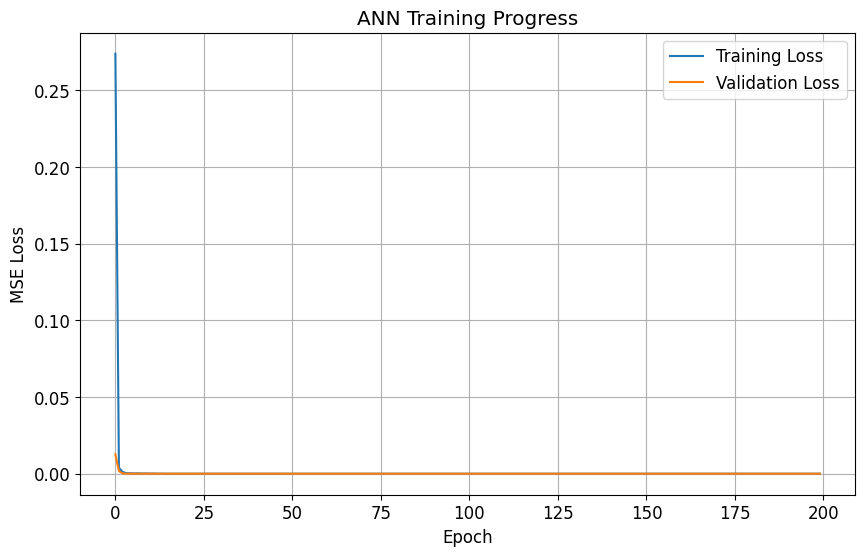

In [23]:
class DynamicANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DynamicANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        # Output activation is linear for regression

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# ANN Hyperparameters
input_dim_ann = ann_input_scaled.shape[1]   # Ca, T, Tc -> 3
output_dim_ann = ann_output_scaled.shape[1] # Ca_next, T_next -> 2
hidden1 = 32
hidden2 = 32
learning_rate = 0.001
num_epochs = 200 # Adjust as needed
batch_size = 64

ann_model = DynamicANN(input_dim_ann, hidden1, hidden2, output_dim_ann)
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=learning_rate)

# Create DataLoader
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_torch, y_val_torch)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

print("Training ANN model...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ann_model.train()
    epoch_train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        outputs = ann_model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))
    
    ann_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs_val, targets_val in val_loader:
            outputs_val = ann_model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)
            epoch_val_loss += loss_val.item()
    val_losses.append(epoch_val_loss / len(val_loader))
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}')

print("ANN training complete.")

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('ANN Training Progress')
plt.legend()
plt.grid(True)
plt.show()

## 4. Validating the Trained ANN Model

Let's see how well the ANN predicts multi-step ahead (simulation) on a new sequence of inputs, compared to the true CSTR model.

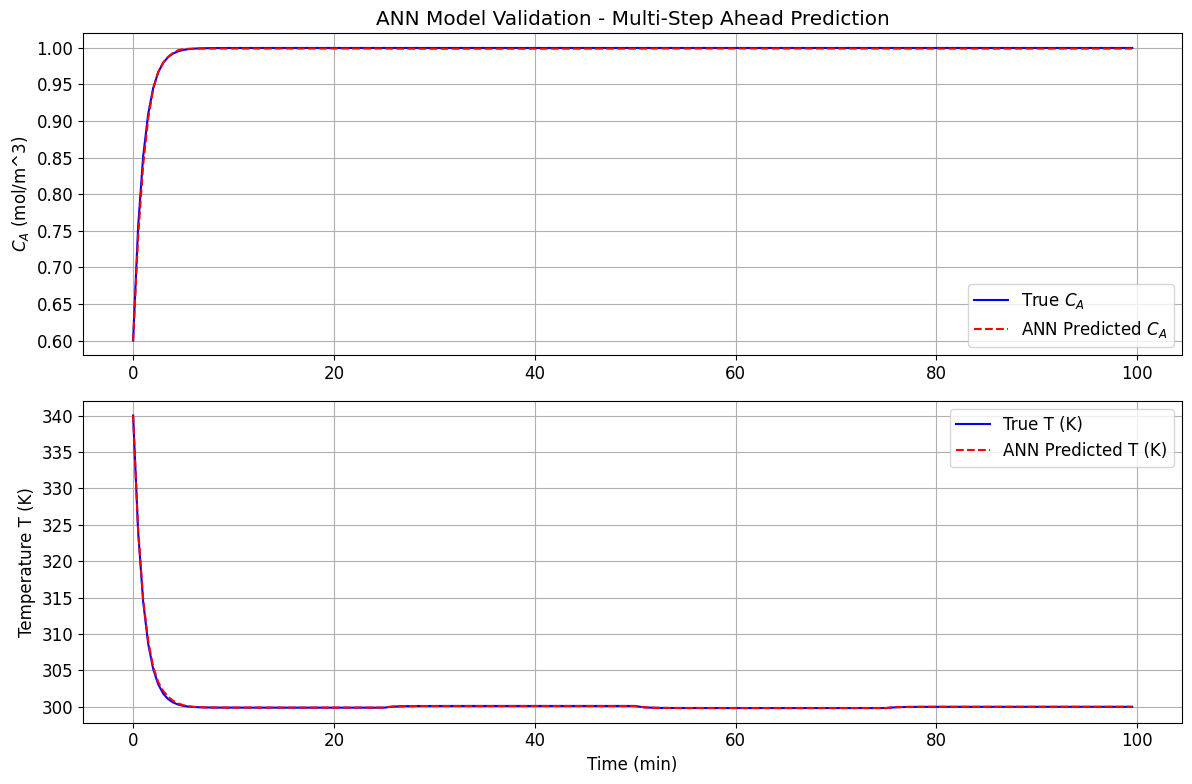

In [24]:
N_test_sim = 200
t_test_sim = np.arange(0, N_test_sim * Ts_data_gen, Ts_data_gen)

# Generate a new test input sequence (e.g., steps or sinusoids)
u_test = np.zeros(N_test_sim)
u_test[0:50] = 290
u_test[50:100] = 310
u_test[100:150] = 285
u_test[150:N_test_sim] = 300

x_true_sim = np.zeros((N_test_sim + 1, 2))
x_ann_sim = np.zeros((N_test_sim + 1, 2))

x_true_sim[0, :] = np.array([0.6, 340.0]) # Initial condition for test
x_ann_sim[0, :] = x_true_sim[0, :].copy()

ann_model.eval() # Set model to evaluation mode
with torch.no_grad():
    for k in range(N_test_sim):
        # True system step
        sol_true = solve_ivp(cstr_ode_numpy, [0, Ts_data_gen], x_true_sim[k, :], 
                               args=(u_test[k], cstr_params_list), method='RK45')
        x_true_sim[k+1, :] = sol_true.y[:, -1]
        
        # ANN prediction step (multi-step ahead)
        current_ann_input_unscaled = np.hstack((x_ann_sim[k, :], u_test[k]))
        current_ann_input_scaled = input_scaler.transform(current_ann_input_unscaled.reshape(1, -1))
        current_ann_input_torch = torch.tensor(current_ann_input_scaled, dtype=torch.float32)
        
        predicted_ann_output_scaled = ann_model(current_ann_input_torch)
        predicted_ann_output_unscaled = output_scaler.inverse_transform(predicted_ann_output_scaled.numpy())
        x_ann_sim[k+1, :] = predicted_ann_output_unscaled.flatten()

# Plot multi-step ahead prediction comparison
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(t_test_sim, x_true_sim[:-1, 0], 'b-', label='True $C_A$')
plt.plot(t_test_sim, x_ann_sim[:-1, 0], 'r--', label='ANN Predicted $C_A$')
plt.ylabel('$C_A$ (mol/m^3)'); plt.grid(True); plt.legend()
plt.title('ANN Model Validation - Multi-Step Ahead Prediction')

plt.subplot(2,1,2)
plt.plot(t_test_sim, x_true_sim[:-1, 1], 'b-', label='True T (K)')
plt.plot(t_test_sim, x_ann_sim[:-1, 1], 'r--', label='ANN Predicted T (K)')
plt.ylabel('Temperature T (K)'); plt.xlabel('Time (min)'); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

## 5. Integrating the PyTorch ANN into CasADi for NMPC

To use our trained `ann_model` (PyTorch) within a CasADi optimization problem, we need a way for CasADi to call this model and, ideally, get its gradients. CasADi's `external` function or its support for importing ONNX models are common ways.

**Method 1: Using CasADi's `external` function (conceptual, requires careful handling of PyTorch AD within CasADi's AD tape).**
This can be complex if CasADi needs to differentiate *through* the PyTorch model. For NMPC, the NLP solver often needs derivatives of the objective/constraints with respect to the control inputs $\mathbf{U}_k$. If the ANN is part of the prediction path $\mathbf{Y}_k = f_{MPC}(\mathbf{U}_k, x_k)$, then gradients of $f_{ANN}$ w.r.t its inputs are needed by CasADi's chain rule.

**Method 2: Export PyTorch model to ONNX, then import ONNX into CasADi.**
ONNX (Open Neural Network Exchange) is an open format for machine learning models. PyTorch can export to ONNX, and CasADi has capabilities to import ONNX models, which then become symbolic CasADi functions.

**Method 3: Re-implementing the ANN in CasADi (for simple ANNs).**
For simple FNNs, one could re-implement the network structure (linear layers, activations) directly using CasADi symbolic variables and use the trained PyTorch weights. This gives CasADi full symbolic access for AD.

**For this notebook, we'll demonstrate Method 3 (Re-implementation) for simplicity, as it gives CasADi full symbolic control and easy AD.** For more complex ANNs or for using pre-built PyTorch models directly, ONNX export/import or careful use of `ca.Function.external` with custom derivative functions would be needed.

*(Note: True black-box integration where CasADi differentiates through PyTorch's autograd tape directly is an advanced topic and might require specific CasADi plugins or careful setup not covered in this introductory notebook.)*

In [25]:
# Re-implement ANN structure in CasADi and load PyTorch weights
# This assumes ann_model is our trained PyTorch model
ann_model.eval() # Ensure it's in eval mode

# Get weights and biases from PyTorch model
W1 = ann_model.fc1.weight.data.numpy().T # Transpose for CasADi convention (features x neurons)
b1 = ann_model.fc1.bias.data.numpy().reshape(-1, 1)
W2 = ann_model.fc2.weight.data.numpy().T
b2 = ann_model.fc2.bias.data.numpy().reshape(-1, 1)
W3 = ann_model.fc3.weight.data.numpy().T
b3 = ann_model.fc3.bias.data.numpy().reshape(-1, 1)

def casadi_relu(x):
    """Implement ReLU activation using CasADi operations"""
    return ca.fmax(0, x)

def ann_casadi_model_scaled(scaled_input_sx, W1, b1, W2, b2, W3, b3):
    """Implements ANN forward pass using CasADi operations"""
    # Convert numpy arrays to CasADi DM (Direct/Dense Matrix)
    # W1: (hidden_size1 x input_dim)
    W1_cas = ca.DM(W1.T)  # Transpose since PyTorch weight is (input_dim x hidden_size1)
    b1_cas = ca.DM(b1)
    # W2: (hidden_size2 x hidden_size1)
    W2_cas = ca.DM(W2.T)  # Transpose since PyTorch weight is (hidden_size1 x hidden_size2)
    b2_cas = ca.DM(b2)
    # W3: (output_dim x hidden_size2)
    W3_cas = ca.DM(W3.T)  # Transpose since PyTorch weight is (hidden_size2 x output_dim)
    b3_cas = ca.DM(b3)
    
    # Forward pass using CasADi operations
    # scaled_input_sx is (input_dim x 1)
    layer1_cas = casadi_relu(W1_cas @ scaled_input_sx + b1_cas)  # (hidden_size1 x 1)
    layer2_cas = casadi_relu(W2_cas @ layer1_cas + b2_cas)      # (hidden_size2 x 1)
    output_scaled_sx = W3_cas @ layer2_cas + b3_cas             # (output_dim x 1)
    
    return output_scaled_sx

# Create a CasADi function for the full ANN model
ann_input_cas_sym = ca.SX.sym('ann_input_cas', input_dim_ann, 1)  # Make column vector explicit
ann_output_scaled_cas_sym = ann_casadi_model_scaled(ann_input_cas_sym, W1, b1, W2, b2, W3, b3)
ann_model_casadi_scaled_func = ca.Function('ann_scaled', [ann_input_cas_sym], [ann_output_scaled_cas_sym])

# Now create a wrapper that includes scaling and unscaling
# For the NMPC, the model function f(xk, uk) should take unscaled xk, uk and return unscaled xk+1
def ann_mpc_model_unscaled(xk_unscaled_sx, uk_unscaled_sx, input_scaler_obj, output_scaler_obj):
    # xk_unscaled_sx (nx,1), uk_unscaled_sx (nu,1)
    # Combine and scale input for ANN
    ann_input_unscaled_sx = ca.vertcat(xk_unscaled_sx, uk_unscaled_sx)
    
    # Scaling: (val - min) / (max - min) = val * scale_ + offset_
    # Need input_scaler.min_ and input_scaler.scale_ (which is 1/(max-min))
    # We assume input_scaler was fit on [x_states, u_inputs]
    # For CasADi, these scale/min values must be numerical constants
    s_min = input_scaler.min_ 
    s_scale = input_scaler.scale_
    
    ann_input_scaled_sx = (ann_input_unscaled_sx - s_min.reshape(-1,1)) * s_scale.reshape(-1,1)
    # If using CasADi's SX.sym for s_min, s_scale, they become part of the graph.
    # For simplicity, let's assume they are fixed for the NMPC problem instance.

    # Get scaled prediction from ANN
    pred_output_scaled_sx = ann_model_casadi_scaled_func(ann_input_scaled_sx)
    
    # Unscale output: val_unscaled = val_scaled / scale_ + min_
    o_min = output_scaler.min_
    o_scale = output_scaler.scale_
    
    pred_output_unscaled_sx = pred_output_scaled_sx / o_scale.reshape(-1,1) + o_min.reshape(-1,1)
    return pred_output_unscaled_sx # This is predicted x_k+1 (unscaled)

print("CasADi wrapper for ANN model created.")
# Test the CasADi ANN function with an example input (requires numerical scalers)
test_x_unscaled = np.array([0.5, 350.0])
test_u_unscaled = np.array([300.0])
test_ann_input_unscaled = np.concatenate((test_x_unscaled, test_u_unscaled))
test_ann_input_scaled_np = input_scaler.transform(test_ann_input_unscaled.reshape(1,-1)).flatten()

casadi_pred_scaled = ann_model_casadi_scaled_func(test_ann_input_scaled_np)
casadi_pred_unscaled = output_scaler.inverse_transform(np.array(casadi_pred_scaled).reshape(1,-1))
print(f"Test CasADi ANN prediction (unscaled): {casadi_pred_unscaled}")

# For PyTorch model prediction for same input (for comparison)
ann_model.eval()
with torch.no_grad():
    pytorch_pred_scaled = ann_model(torch.tensor(test_ann_input_scaled_np, dtype=torch.float32))
    pytorch_pred_unscaled = output_scaler.inverse_transform(pytorch_pred_scaled.numpy().reshape(1,-1))
print(f"Test PyTorch ANN prediction (unscaled): {pytorch_pred_unscaled}")
assert np.allclose(casadi_pred_unscaled, pytorch_pred_unscaled, atol=1e-5), "CasADi and PyTorch ANN outputs differ!"

CasADi wrapper for ANN model created.
Test CasADi ANN prediction (unscaled): [[  0.68859765 330.28865935]]
Test PyTorch ANN prediction (unscaled): [[  0.6885976 330.28867  ]]


## 6. ANN-MPC Implementation and Simulation

Now we set up the NMPC problem using the `ann_mpc_model_unscaled` as our dynamics function $f(x_k, u_k)$ within CasADi's integrator or direct transcription.

In [26]:
# ANN-MPC Parameters
Ts_ann_mpc = Ts_data_gen # Control interval same as ANN training data sampling
Np_ann_mpc = 10      # Prediction horizon

# Objective Function Weights (example)
Q_Ca_ann = 100.0   # Weight for Ca tracking error
Q_T_ann = 1.0     # Weight for T tracking error
R_Tc_ann = 0.1    # Weight for Tc (coolant temp) magnitude
S_Tc_ann = 0.5    # Weight for Tc rate of change

# Constraints
Tc_min_ann_mpc = 280.0; Tc_max_ann_mpc = 320.0
delta_Tc_max_ann_mpc = 5.0 # K per Ts_ann_mpc
Ca_min_ann_mpc = 0.05; Ca_max_ann_mpc = 0.8
T_min_ann_mpc = 300.0; T_max_ann_mpc = 380.0

# Setpoints for Ca and T
Ca_sp_target = 0.3 # mol/m^3
T_sp_target = 330  # K

# --- CasADi ANN-MPC Setup ---
opti_ann_mpc = ca.Opti()
nx_ann = 2 # Ca, T
nu_ann = 1 # Tc

X_ann_pred_sym = opti_ann_mpc.variable(nx_ann, Np_ann_mpc + 1)
U_ann_pred_sym = opti_ann_mpc.variable(nu_ann, Np_ann_mpc)

x0_ann_param = opti_ann_mpc.parameter(nx_ann)
u_prev_ann_param = opti_ann_mpc.parameter(nu_ann)
Ca_sp_ann_param = opti_ann_mpc.parameter(Np_ann_mpc)
T_sp_ann_param = opti_ann_mpc.parameter(Np_ann_mpc)

obj_ann_mpc = 0
for j in range(Np_ann_mpc):
    obj_ann_mpc += Q_Ca_ann * (X_ann_pred_sym[0, j+1] - Ca_sp_ann_param[j])**2
    obj_ann_mpc += Q_T_ann * (X_ann_pred_sym[1, j+1] - T_sp_ann_param[j])**2
    obj_ann_mpc += R_Tc_ann * (U_ann_pred_sym[0, j])**2
    delta_u_ann = U_ann_pred_sym[0, j] - (u_prev_ann_param[0] if j==0 else U_ann_pred_sym[0, j-1])
    obj_ann_mpc += S_Tc_ann * delta_u_ann**2
opti_ann_mpc.minimize(obj_ann_mpc)

# Dynamic constraints using the ANN model
opti_ann_mpc.subject_to(X_ann_pred_sym[:,0] == x0_ann_param)
for j in range(Np_ann_mpc):
    # Current state x_j and input u_j for ANN model
    xk_unscaled_for_ann = X_ann_pred_sym[:,j]
    uk_unscaled_for_ann = U_ann_pred_sym[:,j]
    
    # Call the CasADi wrapper for the ANN model
    # Need to pass the actual scaler objects, or hardcode their params in a pure CasADi func
    # For this to work within opti, ann_mpc_model_unscaled needs to be a pure CasADi function
    # Let's define a new pure CasADi version using the numerical scaler values
    s_min_vals = input_scaler.min_
    s_scale_vals = input_scaler.scale_
    o_min_vals = output_scaler.min_
    o_scale_vals = output_scaler.scale_
    
    def ann_pure_casadi_f(xk_sx, uk_sx):
        ann_input_unsc_sx = ca.vertcat(xk_sx, uk_sx)
        ann_input_sc_sx = (ann_input_unsc_sx - s_min_vals.reshape(-1,1)) * s_scale_vals.reshape(-1,1)
        pred_out_sc_sx = ann_model_casadi_scaled_func(ann_input_sc_sx)
        pred_out_unsc_sx = pred_out_sc_sx / o_scale_vals.reshape(-1,1) + o_min_vals.reshape(-1,1)
        return pred_out_unsc_sx
    
    x_next_pred_ann = ann_pure_casadi_f(xk_unscaled_for_ann, uk_unscaled_for_ann)
    opti_ann_mpc.subject_to(X_ann_pred_sym[:,j+1] == x_next_pred_ann)
    
    # Other constraints
    opti_ann_mpc.subject_to(opti_ann_mpc.bounded(Tc_min_ann_mpc, U_ann_pred_sym[0,j], Tc_max_ann_mpc))
    delta_u_c_ann = U_ann_pred_sym[0,j] - (u_prev_ann_param[0] if j==0 else U_ann_pred_sym[0,j-1])
    opti_ann_mpc.subject_to(opti_ann_mpc.bounded(-delta_Tc_max_ann_mpc, delta_u_c_ann, delta_Tc_max_ann_mpc))
    opti_ann_mpc.subject_to(opti_ann_mpc.bounded(Ca_min_ann_mpc, X_ann_pred_sym[0,j+1], Ca_max_ann_mpc))
    opti_ann_mpc.subject_to(opti_ann_mpc.bounded(T_min_ann_mpc, X_ann_pred_sym[1,j+1], T_max_ann_mpc))

opts_ann_mpc = {'ipopt.max_iter': 100, 'ipopt.print_level': 0, 'print_time': 0,
                'ipopt.acceptable_tol': 1e-6}
opti_ann_mpc.solver('ipopt', opts_ann_mpc)
print("ANN-MPC problem formulated.")

# --- ANN-MPC Simulation Loop ---
sim_time_ann_mpc_total = 60 # min
num_sim_steps_ann_mpc = int(sim_time_ann_mpc_total / Ts_ann_mpc)

x_plant_ann_mpc_current = np.array([0.6, 340.0]) # True initial plant state [Ca, T]
u_plant_ann_mpc_prev = np.array([300.0])      # Initial previous input Tc

Ca_sp_horizon_ann = np.full(Np_ann_mpc, Ca_sp_target)
T_sp_horizon_ann = np.full(Np_ann_mpc, T_sp_target)

t_log_ann_mpc = np.zeros(num_sim_steps_ann_mpc + 1)
X_log_ann_mpc_plant = np.zeros((nx_ann, num_sim_steps_ann_mpc + 1))
U_log_ann_mpc = np.zeros((nu_ann, num_sim_steps_ann_mpc))

X_log_ann_mpc_plant[:, 0] = x_plant_ann_mpc_current
t_log_ann_mpc[0] = 0

U_guess_ann_mpc = np.full((nu_ann, Np_ann_mpc), np.mean([Tc_min_ann_mpc, Tc_max_ann_mpc]))
X_guess_ann_mpc = np.tile(x_plant_ann_mpc_current.reshape(nx_ann,1), (1, Np_ann_mpc + 1))

print(f"Starting ANN-MPC simulation for {num_sim_steps_ann_mpc} steps...")
for k in range(num_sim_steps_ann_mpc):
    current_t_ann_mpc = k * Ts_ann_mpc
    print(f"ANN-MPC Step {k+1}/{num_sim_steps_ann_mpc} (t={current_t_ann_mpc:.1f} min)", end='\r')
    
    opti_ann_mpc.set_value(x0_ann_param, x_plant_ann_mpc_current)
    opti_ann_mpc.set_value(u_prev_ann_param, u_plant_ann_mpc_prev)
    opti_ann_mpc.set_value(Ca_sp_ann_param, Ca_sp_horizon_ann)
    opti_ann_mpc.set_value(T_sp_ann_param, T_sp_horizon_ann) 
    
    opti_ann_mpc.set_initial(X_ann_pred_sym, X_guess_ann_mpc)
    opti_ann_mpc.set_initial(U_ann_pred_sym, U_guess_ann_mpc)
    
    try:
        sol_ann_mpc = opti_ann_mpc.solve()
        U_opt_ann_mpc = sol_ann_mpc.value(U_ann_pred_sym)
        X_pred_ann_mpc = sol_ann_mpc.value(X_ann_pred_sym)
        u_to_apply_ann_mpc = U_opt_ann_mpc[:, 0]
        X_guess_ann_mpc = np.hstack((X_pred_ann_mpc[:, 1:], X_pred_ann_mpc[:, -1].reshape(nx_ann,1)))
        U_guess_ann_mpc = np.hstack((U_opt_ann_mpc[:, 1:], U_opt_ann_mpc[:, -1].reshape(nu_ann,1)))
    except RuntimeError as e:
        print(f"\nANN-MPC Solver failed at step {k+1}: {e}. Using previous input.")
        u_to_apply_ann_mpc = u_plant_ann_mpc_prev.flatten()
        U_guess_ann_mpc = np.full((nu_ann, Np_ann_mpc), u_plant_ann_mpc_prev[0])
        X_guess_ann_mpc = np.tile(x_plant_ann_mpc_current.reshape(nx_ann,1), (1, Np_ann_mpc + 1))

    U_log_ann_mpc[:, k] = u_to_apply_ann_mpc
    
    # True Plant Evolution (using CSTR ODEs)
    plant_sol_ann_mpc_step = solve_ivp(cstr_ode_numpy, 
                                     [current_t_ann_mpc, current_t_ann_mpc + Ts_ann_mpc], 
                                     x_plant_ann_mpc_current, 
                                     args=(u_to_apply_ann_mpc[0], cstr_params_list), 
                                     dense_output=False, t_eval=[current_t_ann_mpc + Ts_ann_mpc],
                                     method='RK45')
    x_plant_ann_mpc_current = plant_sol_ann_mpc_step.y[:,-1]
    
    X_log_ann_mpc_plant[:, k+1] = x_plant_ann_mpc_current
    t_log_ann_mpc[k+1] = current_t_ann_mpc + Ts_ann_mpc
    u_plant_ann_mpc_prev = u_to_apply_ann_mpc.reshape(nu_ann,1)

print("\nANN-MPC simulation finished.")

ANN-MPC problem formulated.
Starting ANN-MPC simulation for 120 steps...
ANN-MPC Step 1/120 (t=0.0 min)
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


ANN-MPC Solver failed at step 1: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'. Using previous input.
ANN-MPC Step 2/120 (t=0.5 min)
ANN-MPC Solver failed at step 2: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/o

## 7. Visualizing ANN-MPC Performance

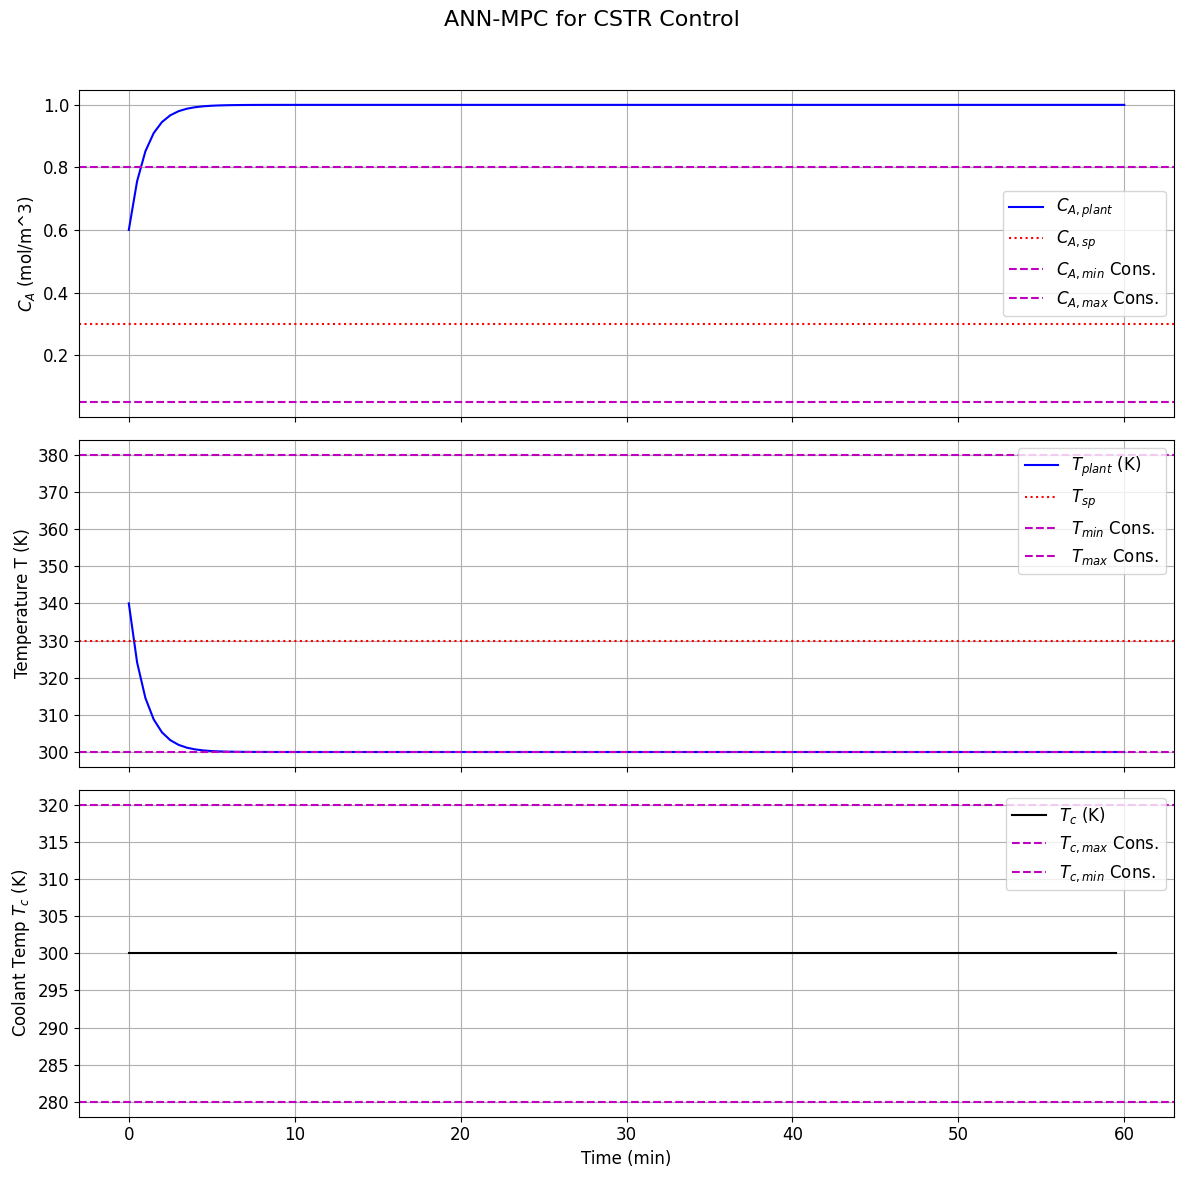

In [27]:
fig_ann, axs_ann = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig_ann.suptitle(f'ANN-MPC for CSTR Control', fontsize=16)
time_plot_ann = t_log_ann_mpc
time_u_plot_ann = t_log_ann_mpc[:-1]

# CA
axs_ann[0].plot(time_plot_ann, X_log_ann_mpc_plant[0, :], 'b-', label='$C_{A,plant}$')
axs_ann[0].axhline(Ca_sp_target, color='r', linestyle=':', label='$C_{A,sp}$')
axs_ann[0].axhline(Ca_min_ann_mpc, color='m', ls='--', label='$C_{A,min}$ Cons.')
axs_ann[0].axhline(Ca_max_ann_mpc, color='m', ls='--', label='$C_{A,max}$ Cons.')
axs_ann[0].set_ylabel('$C_A$ (mol/m^3)'); axs_ann[0].grid(True); axs_ann[0].legend()

# T
axs_ann[1].plot(time_plot_ann, X_log_ann_mpc_plant[1, :], 'b-', label='$T_{plant}$ (K)')
axs_ann[1].axhline(T_sp_target, color='r', linestyle=':', label='$T_{sp}$')
axs_ann[1].axhline(T_min_ann_mpc, color='m', ls='--', label='$T_{min}$ Cons.')
axs_ann[1].axhline(T_max_ann_mpc, color='m', ls='--', label='$T_{max}$ Cons.')
axs_ann[1].set_ylabel('Temperature T (K)'); axs_ann[1].grid(True); axs_ann[1].legend()

# Control Input Tc
axs_ann[2].step(time_u_plot_ann, U_log_ann_mpc[0, :], 'k-', where='post', label='$T_c$ (K)')
axs_ann[2].axhline(Tc_max_ann_mpc, color='m', ls='--', label='$T_{c,max}$ Cons.')
axs_ann[2].axhline(Tc_min_ann_mpc, color='m', ls='--', label='$T_{c,min}$ Cons.')
axs_ann[2].set_ylabel('Coolant Temp $T_c$ (K)'); axs_ann[2].set_xlabel('Time (min)'); axs_ann[2].grid(True); axs_ann[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 8. Discussion and Exercises

*   **ANN Model Accuracy:** How well did the ANN model (from validation in Section 4) predict the true CSTR behavior? If the ANN model is inaccurate, the ANN-MPC performance will suffer.
*   **ANN-MPC Performance:** Does the ANN-MPC effectively track the setpoints for $C_A$ and $T$? How does it handle constraints?
*   **Comparison:**
    *   If you implemented NMPC with the true CSTR model (e.g., in Notebook 3.3 or 8.6 from main course), how does this ANN-MPC compare?
    *   How might an LMPC (linearized CSTR model) perform on this task, especially if the setpoint change is large?
*   **Tuning:** Experiment with the ANN-MPC weights ($Q_{Ca}, Q_T, R_{Tc}, S_{Tc}$) and the prediction horizon $N_p$. How do they affect closed-loop behavior and computational demand?
*   **Extrapolation:** The ANN model is only reliable within the range of data it was trained on. If the MPC tries to drive the system far outside this range, the ANN's predictions might become poor, leading to bad control actions. How could this be mitigated conceptually?
*   **Computational Cost:** Is the ANN-MPC significantly slower or faster to solve per step compared to an NMPC using the analytical ODEs (if you have a comparison)? This depends on the ANN complexity and the ODE complexity.
*   **Alternative ANN Structures:** We used a simple FNN. Would an RNN (like LSTM or GRU) potentially offer better performance for modeling dynamics, especially if there are longer-term dependencies not captured by a simple FNN taking only $x_k, u_k$ as input?

This notebook demonstrates that a learned ANN model can indeed be used as the predictive core for an NMPC controller. The success heavily relies on the quality of the training data and the generalization capability of the ANN.

## 9. Key Takeaways

*   Artificial Neural Networks can be trained to learn the dynamics of nonlinear systems from input-output data.
*   A trained ANN can serve as the prediction model within an NMPC framework.
*   Integrating ANNs (especially from frameworks like PyTorch/TensorFlow) into CasADi for NMPC often involves re-implementing the ANN structure symbolically or using ONNX conversion to leverage CasADi's automatic differentiation for the NLP solver.
*   The performance of ANN-MPC is highly dependent on the quality of the ANN model, which in turn depends on the training data, network architecture, and training process.
*   Challenges include the "black-box" nature, potential for poor extrapolation, and ensuring the ANN model is suitable for multi-step prediction within the MPC horizon.

In the next notebook (**Notebook 6.3: MPC with Physics-Informed Neural Network (PINN) Models**), we will explore PINNs, a hybrid approach that attempts to combine the learning power of ANNs with known physical laws to create more robust and data-efficient models.